Before starting to work we have to import the following library, pay attention that **crossentropy**, **sequence** and **unet** have to uploaded in the notebook. You can find them in notebooks/utility/  .



In [ ]:
!pip install tensorflow_addons
 
from tensorflow.keras.layers import Input, concatenate, Lambda, Activation, UpSampling2D, Concatenate
from tensorflow.keras.layers import Convolution2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Dropout, Cropping2D
from tensorflow.keras import Model
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import tensorflow_addons as tfa
import math
import cv2
from sklearn.utils import shuffle
from crossentropy import MyCrossentropy 
from sequence import FoodSequence
#from utilities import MyCrossentropy, FoodSequence
from unet import UNet
 
 
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print('Loading UNet model')
model = tf.keras.models.load_model('/content/drive/My Drive/Food recognition challenge/models/unet/architecture', custom_objects={"UNet": UNet}, compile=False)
print('Model loaded')


Loading UNet model
Model loaded


In [ ]:
loading_path = '/content/drive/My Drive/Food recognition challenge/models/unet/weights/unet_weights_epoch100.h5'
print('Loading weights of epoch',  loading_path[-5:-3])
model.load_weights(loading_path)
print('Weights loaded')

Loading weights of epoch 00
Weights loaded


In [ ]:
#Data set downloading 

!pip install -U aicrowd-cli
API_KEY = "67587f4b3488144e75864045bf9db5e9" #get your api-key from https://www.aicrowd.com/participants/me

!aicrowd login --api-key $API_KEY 

!aicrowd dataset download --challenge food-recognition-challenge 3 4 5
!tar -zxvf train-v0.4.tar.gz

     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 174kB 26.7MB/s 
     |████████████████████████████████| 81kB 12.0MB/s 
     |████████████████████████████████| 215kB 48.9MB/s 
     |████████████████████████████████| 71kB 12.3MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


Output streaming troncato alle ultime 5000 righe.
./train/images/016635.jpg
./train/images/084765.jpg
./train/images/030078.jpg
./train/images/095272.jpg
./train/images/074596.jpg
./train/images/068251.jpg
./train/images/021057.jpg
./train/images/098101.jpg
./train/images/094285.jpg
./train/images/007293.jpg
./train/images/099408.jpg
./train/images/019538.jpg
./train/images/049791.jpg
./train/images/021889.jpg
./train/images/075978.jpg
./train/images/043050.jpg
./train/images/077428.jpg
./train/images/026325.jpg
./train/images/008192.jpg
./train/images/082412.jpg
./train/images/013239.jpg
./train/images/028513.jpg
./train/images/084736.jpg
./train/images/076279.jpg
./train/images/103474.jpg
./train/images/070743.jpg
./train/images/071644.jpg
./train/images/095290.jpg
./train/images/037048.jpg
./train/images/009347.jpg
./train/images/078783.jpg
./train/images/084642.jpg
./train/images/032499.jpg
./train/images/099724.jpg
./train/images/079743.jpg
./train/images/074193.jpg
./train/images

Data preprocessing

In [ ]:

file = open("train/annotations.json", "r")
annotations = json.loads(file.read())

ann = pd.DataFrame(annotations['annotations'])
mapping = {item:i for i, item in enumerate(ann["category_id"].unique())} 
ann["category_id"] = ann["category_id"].apply(lambda x: mapping[x])

annotations_map = {img_id: {} for img_id in ann['image_id'].unique()}
for index, row in ann.iterrows():
    annotations_map[row['image_id']][row['category_id']] = row['segmentation']

images = pd.DataFrame(annotations['images']).set_index('id')
categories = pd.DataFrame(annotations['categories'])
categories['id'] = categories['id'].apply(lambda x: mapping[x])
categories = categories.set_index('id')

In [ ]:
dataset = FoodSequence(images, annotations_map, len(categories), img_size=(256, 256), batch_size=8)

Weights computation


In [ ]:
classes_total_area = ann.groupby(by='category_id')['area'].sum()
category_weights = np.max(classes_total_area) / classes_total_area
category_weights = np.float32(category_weights)
beta = 100  



model.compile(
    optimizer='adam', 
    loss=MyCrossentropy(category_weights, beta=beta)
    )



Training step

In [ ]:
saving_path = '/content/drive/My Drive/Food recognition challenge/notebooks/U-Net/weights/unet_weights_epoch100.h5'
print('Training Model')
history = model.fit(dataset)
print('Saving model')
model.save_weights(saving_path)
print('Weights saved for epoch', saving_path[-5:-3])
loss = history.history
print('loss =', loss['loss'][0])

loss_path = '/content/drive/My Drive/Food recognition challenge/notebooks/U-Net/loss.txt'
f = open(loss_path, 'a')
f.write('\n')
f.write(str(round(loss['loss'][0], 4)))
f.close()

Validation step

In [ ]:
val_file = open("val/annotations.json", "r")
val_annotations = json.loads(val_file.read())
 
val_ann = pd.DataFrame(val_annotations['annotations'])
val_ann["category_id"] = val_ann["category_id"].apply(lambda x: mapping[x])
val_annotations_map = {img_id: {} for img_id in val_ann['image_id'].unique()}
for index, row in val_ann.iterrows():
    val_annotations_map[row['image_id']][row['category_id']] = row['segmentation']
val_images = pd.DataFrame(val_annotations['images'])
val_images = val_images.set_index('id')
 
val_set = FoodSequence(val_images, val_annotations_map, len(categories), batch_size=1, folder='val',img_size=(256, 256), data_augmentation=False)


In [ ]:
print('Validation loss for epoch', loading_path[-5:-3])
eval = model.evaluate(val_set)
print(eval)

val_loss_path = '/content/drive/My Drive/Food recognition challenge/notebooks/U-Net/val_loss.txt'
f = open(val_loss_path, 'a')
f.write('\n')
f.write(str(round(eval, 4)))
f.close()

In [ ]:
def desired_output(img_shape, segmentations):
        desired_output = np.zeros((img_shape[0], img_shape[1], len(categories)), dtype=np.int32)
 
        for i in segmentations:
          t = np.zeros((img_shape[0], img_shape[1], 1), dtype=np.int32)
          for seg in segmentations[i]:
              s = np.array(seg, dtype=np.int32).reshape((-1, 2))
              t = cv2.fillPoly(t, [s], 255)
 
          desired_output[:, :, i] = t.squeeze()
 
        return desired_output / 25


def binarize(y_pred, threshold):
    y_pred_bin = np.zeros((y_pred.shape[1], y_pred.shape[2], y_pred.shape[3]))
    for i in range(0, 273):
      y_pred_bin[:, :, i] = tf.where(y_pred[0, :, :, i] > threshold, 1.0, 0.0)
    
    return tf.cast(y_pred_bin, dtype=tf.dtypes.float32)

def IoU(mask, y_pred, threshold=0.6):
  y = y_pred > threshold
  intersection = tf.math.count_nonzero(tf.boolean_mask(y, mask))
  union = tf.math.count_nonzero(mask + tf.cast(y, dtype=tf.float32))
  return  intersection / union

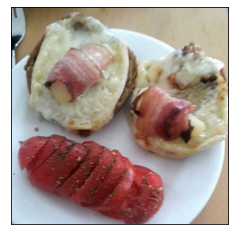

loss:  0.24431957
loss of zeros:  1.3543907
There is a bacon-frying with max 0.63607204
There is a cheese-for-raclette with max 0.61106247
There is a tomato with max 0.4988651
There is a bread-wholemeal with max 0.35503387
There are 160 categories more likely than the true min


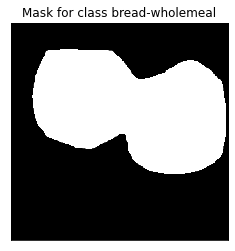

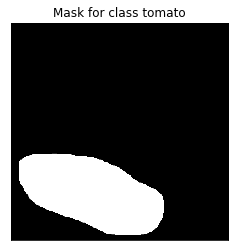

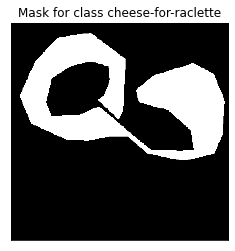

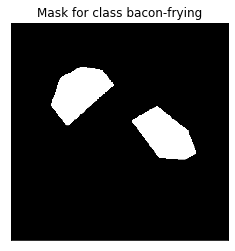

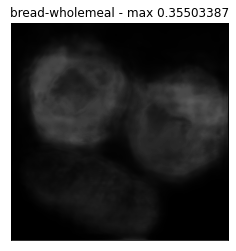

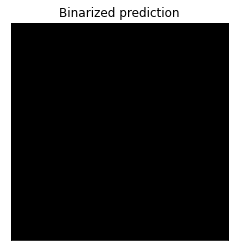

IoU for class bread-wholemeal = 0.0 


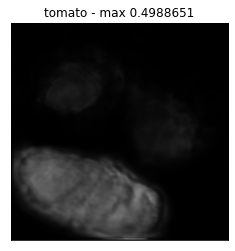

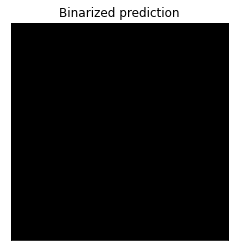

IoU for class tomato = 0.0 


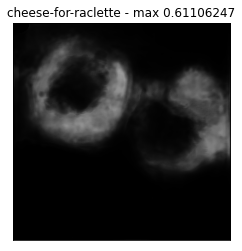

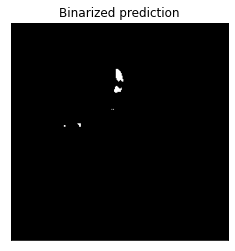

IoU for class cheese-for-raclette = 0.010600469641060047 


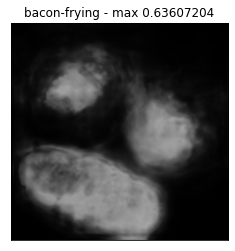

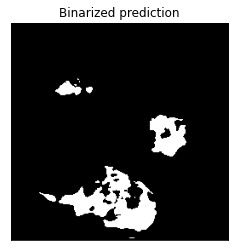

IoU for class bacon-frying = 0.17787069797362495 


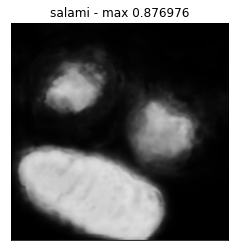

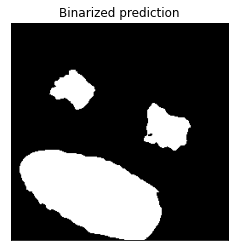

IoU for class salami = 0.0 


In [ ]:
#img_id = val_images.sample().index.values[0]
img = cv2.imread('val/images/' + val_images.loc[img_id, 'file_name'])
 
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xticks([])
plt.yticks([])
plt.show()
 
input_img = cv2.resize(img, dsize=(256, 256)) / 255
y = model.predict(input_img.reshape((1, input_img.shape[0], input_img.shape[1], input_img.shape[2])))
 
img_ann = val_ann[val_ann['image_id'] == img_id]
segmentations = dict(zip(img_ann['category_id'], img_ann['segmentation']))
y_true = desired_output(img.shape, segmentations)
y_true = cv2.resize(y_true, dsize=(256, 256), interpolation=cv2.INTER_NEAREST)
print("loss: ", MyCrossentropy(category_weights, beta=beta)(y_true, y).numpy())
print("loss of zeros: ", MyCrossentropy(category_weights, beta=beta)(y_true, np.zeros((1, 256, 256, 273), dtype=np.float32)).numpy())


 
min_of_seg = 1
for seg in segmentations:
  seg_max = np.max(y[0, :, :, seg])
  print("There is a", categories.iloc[seg]['name'], "with max", seg_max)
  if seg_max < min_of_seg:
    min_of_seg = seg_max
 
more_likely = [np.any(y[0, :, :, i] > min_of_seg) for i in range(len(categories))]
print("There are", np.count_nonzero(more_likely), "categories more likely than the true min")

 
for i in range(len(categories)):

  if i in segmentations:
      plt.title('Mask for class {}'.format(categories.iloc[i]['name']))
      plt.imshow(y_true[:, :, i], cmap='gray', vmin = 0, vmax = 1)
      plt.xticks([])
      plt.yticks([])
      plt.show()
 
for i in range(len(categories)):

  if np.any(y[0, :, :, i] >= np.max(y)) or i in segmentations:

    fig = plt.figure()
    plt.title(categories.iloc[i]['name'] + " - max " + str(np.max(y[0, :, :, i])))
    plt.imshow(y[0, :, :, i], cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    plt.title('Real mask')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y[0,:,:,i])

    plt.title('Binarized prediction')
    binarized = binarize(y, 0.55)
    plt.imshow(binarized[:, :, i], cmap='gray', vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
    iou = IoU(y_true[:, :, i], binarized[:, :, i]).numpy()
    print('IoU for class {} = {} '.format(categories.iloc[i]['name'], iou))



